With thorough explanation, write a code that uses a deep learning model to classification multiple binary outputs in a CVD multi morbidity study. The predictors are age, sex, SES, hypertension, BMI, smoking, CIMT, subcutaneous fat, visceral fat, study site (4), and alcohol use. the target variables are stroke, TIA, angina, and congestive heart failure. The targets are binary outputs (0 and 1). 
Use correlation coefficients and VIF to find correlate variables.
Use a stratification process for sex and study sites, use a class weight optimisation for the class imbalance for the target variables. 
Use a SHAP model for at least three types of analysis. 
Use a counterfactual to analyse.
<!-- In a separate study, repeat these analysis but use PCA and LASSO to choose variables. -->

In [16]:
from random import random
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import shap
import fairlearn
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.metrics import accuracy_score
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import StandardDataset

In [17]:
# Simple Function to calcuate CVD
def calculate_CVD(a,b,c,d,e):
    col=0
    if (int(a)==1 or int(b)==1 or int(c)==1 or int(d)==1 or int(e)==1):
        col=1
    elif (int(a)==0 and int(b)==0 and int(c)==0 and int(d)==0 and int(e)==0):
        col = 0
    elif (int(a)==pd.isna and int(b)==pd.isna and int(c)==pd.isna and int(d)==pd.isna and int(e)==pd.isna):
        col = 0
    return col

In [18]:
data = pd.read_csv('cardio_train1.csv')
# print(data.head())


# # EDA and preproccesing 
# print(data.isna().sum())
X = data.iloc[:, 1:-1]
Y = data.iloc[:, -1]


In [ ]:
## Function to define CVD variable
# com=[]
# for i in range(data.shape[0]):
#     com.append(calculate_CVD(data.stroke_qc.iloc[i], data.transient_ischemic_attack_qc.iloc[i], data.heartattack_qc.iloc[i], data.congestive_heart_failure_qc.iloc[i], data.angina_qc.iloc[i]))

# y1=pd.DataFrame(com, columns=['CVD'])

In [19]:
XX = ['age', 'gender', 'weight', 'ap_hi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
YY = ['cardio']

In [20]:
data[YY]

,cardio
0,0
1,1
2,1
3,1
4,0
...,...
69995,0
69996,1
69997,1
69998,1


In [21]:
X1 = data[XX]

# make target variable
y = data.pop('cardio')


In [22]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, random_state=1)

In [23]:
scaler = StandardScaler().fit(X_train1[XX]) 

X_train1[XX] = scaler.transform(X_train1[XX])
X_test1[XX] = scaler.transform(X_test1[XX])

Epoch 1/30
4773/4773 [==============================] - 3s 486us/step - loss: 0.6357 - accuracy: 0.6339 - val_loss: 0.5734 - val_accuracy: 0.7202
Epoch 2/30
4773/4773 [==============================] - 2s 397us/step - loss: 0.5660 - accuracy: 0.7227 - val_loss: 0.5627 - val_accuracy: 0.7265
Epoch 3/30
4773/4773 [==============================] - 2s 384us/step - loss: 0.5617 - accuracy: 0.7247 - val_loss: 0.5559 - val_accuracy: 0.7287
Epoch 4/30
4773/4773 [==============================] - 2s 393us/step - loss: 0.5521 - accuracy: 0.7301 - val_loss: 0.5527 - val_accuracy: 0.7306
Epoch 5/30
4773/4773 [==============================] - 2s 417us/step - loss: 0.5511 - accuracy: 0.7304 - val_loss: 0.5516 - val_accuracy: 0.7281
Epoch 6/30
4773/4773 [==============================] - 2s 394us/step - loss: 0.5401 - accuracy: 0.7360 - val_loss: 0.5437 - val_accuracy: 0.7325
Epoch 7/30
4773/4773 [==============================] - 2s 397us/step - loss: 0.5458 - accuracy: 0.7316 - val_loss: 0.5426 -

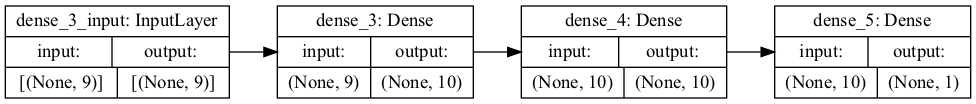

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

model.compile(optimizer="adam", 
              loss ="binary_crossentropy", 
              metrics=["accuracy"])

model.fit(X_train1, y_train1, 
         epochs=30, 
         batch_size=11,
         validation_data=(X_test1, y_test1)
         )

tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [25]:
shap.initjs()
# explainer = shap.Explainer(mm)
explainer1 = shap.KernelExplainer(model, X_test1.iloc[1:500])
# shap_values = explainer(X_test)
shap_values1 = explainer1.shap_values(X_test1.iloc[50], nsamples=1000)

In [26]:
shap.force_plot(explainer1.expected_value[0], shap_values1[0], X_test1.iloc[20,:])

In [27]:
shap_values501 = explainer1.shap_values(X_test1.iloc[5:100,:], nsamples=500)

  0%|          | 0/95 [00:00<?, ?it/s]

In [28]:
shap.force_plot(explainer1.expected_value, shap_values501[0], X_test1.iloc[5:100,:])

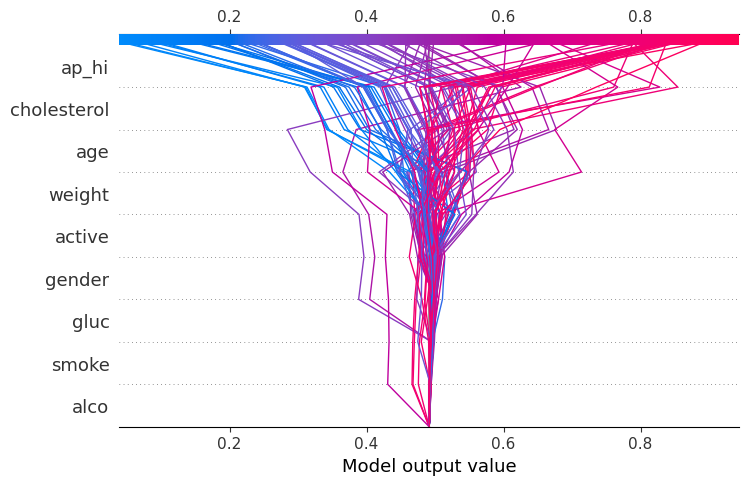

In [31]:
# shap.decision_plot(explainer1.expected_value[0], shap_values[0], features = X_test[1:50,:], feature_names =['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo' 'cholesterol', 'gluc', 'smoke', 'alco', 'active'])
shap.decision_plot(explainer1.expected_value[0], shap_values501[0], features = X_test1.iloc[1:50,:])

In [37]:
# Create a counterfactual example by modifying specific features
counterfactual_example = X_test1.iloc[0].copy()
counterfactual_example['gluc'] += 0.5  # Modify the BMI by subtracting 5

# Get the predicted probabilities for the counterfactual example
counterfactual_probs = model.predict(np.expand_dims(counterfactual_example, axis=0))

# Print the counterfactual example and predicted probabilities
print("Counterfactual Example:")
print(counterfactual_example)
print("\nPredicted Probabilities for Counterfactual Example:")
print(counterfactual_probs)

Counterfactual Example:
age           -1.363034
gender        -0.734629
weight         1.296102
ap_hi          0.074834
cholesterol   -0.540096
gluc           0.104198
smoke         -0.312433
alco          -0.239320
active         0.496486
Name: 6670, dtype: float64

Predicted Probabilities for Counterfactual Example:
[[0.8459686]]
